In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Load data from _annotations.csv
def load_data(csv_path, img_dir):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    bboxes = []

    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['filename'])
        img = tf.keras.preprocessing.image.load_img(img_path)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, (224, 224))  # Resize for MobileNetV2
        images.append(img)

        # Normalize bounding box coordinates (to range 0-1)
        bbox = [
            row['xmin'] / row['width'],
            row['ymin'] / row['height'],
            row['xmax'] / row['width'],
            row['ymax'] / row['height'],
        ]
        bboxes.append(bbox)
        labels.append(row['class'])

    return np.array(images), np.array(labels), np.array(bboxes)

# Load train, validation, and test datasets
train_images, train_labels, train_bboxes = load_data('train/_annotations.csv', 'train')
val_images, val_labels, val_bboxes = load_data('valid/_annotations.csv', 'valid')
test_images, test_labels, test_bboxes = load_data('test/_annotations.csv', 'test')

# One-hot encode labels
unique_classes = sorted(set(train_labels))
label_map = {label: idx for idx, label in enumerate(unique_classes)}

train_labels = np.array([label_map[label] for label in train_labels])
val_labels = np.array([label_map[label] for label in val_labels])
test_labels = np.array([label_map[label] for label in test_labels])

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(unique_classes))
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=len(unique_classes))

# Normalize images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom generator to augment both images and bounding boxes
def data_generator(images, labels, bboxes, batch_size, augmenter):
    while True:
        indices = np.random.choice(len(images), batch_size, replace=False)
        batch_images = images[indices]
        batch_labels = labels[indices]
        batch_bboxes = bboxes[indices]

        # Augment only the images
        augmented_images = np.zeros_like(batch_images)
        for i, img in enumerate(batch_images):
            augmented = augmenter.random_transform(img)
            augmented_images[i] = augmented

        yield augmented_images, {'class_output': batch_labels, 'bbox_output': batch_bboxes}

# Generator instance for training
train_generator = data_generator(
    train_images, train_labels, train_bboxes, batch_size=32, augmenter=augmenter
)


In [4]:
# print(df.head())
# print(df.columns)


In [5]:
# Create the model with transfer learning
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze for fine-tuning

# Add custom layers for classification and bounding box regression
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)  # Dropout for regularization
x = layers.Dense(512, activation='relu')(x)  # Additional dense layer

# Classification output
class_output = layers.Dense(len(unique_classes), activation='softmax', name='class_output')(x)

# Bounding box output
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

model = tf.keras.Model(inputs=inputs, outputs=[class_output, bbox_output])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss={
        'class_output': 'categorical_crossentropy',
        'bbox_output': 'mse',
    },
    metrics={
        'class_output': 'accuracy',
    }
)

# Model training using custom generator
history = model.fit(
    train_generator,
    validation_data=(val_images, {'class_output': val_labels, 'bbox_output': val_bboxes}),
    steps_per_epoch=len(train_images) // 32,
    validation_steps=len(val_images) // 32,
    epochs=30
)



Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - bbox_output_loss: 0.0982 - class_output_accuracy: 0.0915 - class_output_loss: 3.0137 - loss: 3.1120 - val_bbox_output_loss: 0.0951 - val_class_output_accuracy: 0.2922 - val_class_output_loss: 2.4106 - val_loss: 2.5186
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - bbox_output_loss: 0.0799 - class_output_accuracy: 0.2892 - class_output_loss: 2.3823 - loss: 2.4622 - val_bbox_output_loss: 0.0788 - val_class_output_accuracy: 0.3629 - val_class_output_loss: 2.1107 - val_loss: 2.2046
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - bbox_output_loss: 0.0709 - class_output_accuracy: 0.3790 - class_output_loss: 2.0869 - loss: 2.1578 - val_bbox_output_loss: 0.0679 - val_class_output_accuracy: 0.4072 - val_class_output_loss: 1.8796 - val_loss: 1.9615
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - bbox_output_loss: 0.0658 - class_output_accuracy: 0.4879 - class_output_loss: 1.8124 - loss: 1.8782 - val_bbox_output_loss: 0.0621 - v

In [6]:
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(unique_classes))


# Evaluate the model
results = model.evaluate(
    test_images, {'class_output': test_labels, 'bbox_output': test_bboxes}
)
print(f"Test Loss (total): {results[0]}")
print(f"Test Loss (class_output): {results[1]}")
print(f"Test Loss (bbox_output): {results[2]}")
print(f"Test Accuracy (class_output): {results[3]}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - bbox_output_loss: 0.0515 - class_output_accuracy: 0.8376 - class_output_loss: 0.6351 - loss: 0.6745
Test Loss (total): 0.778679370880127
Test Loss (class_output): 0.822361946105957
Test Loss (bbox_output): 0.052913520485162735
Test Accuracy (class_output): 0.7922077775001526


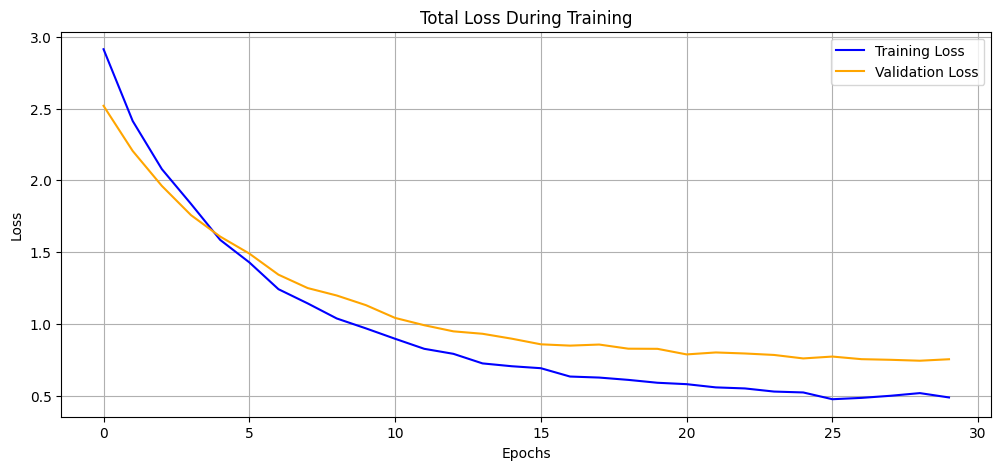

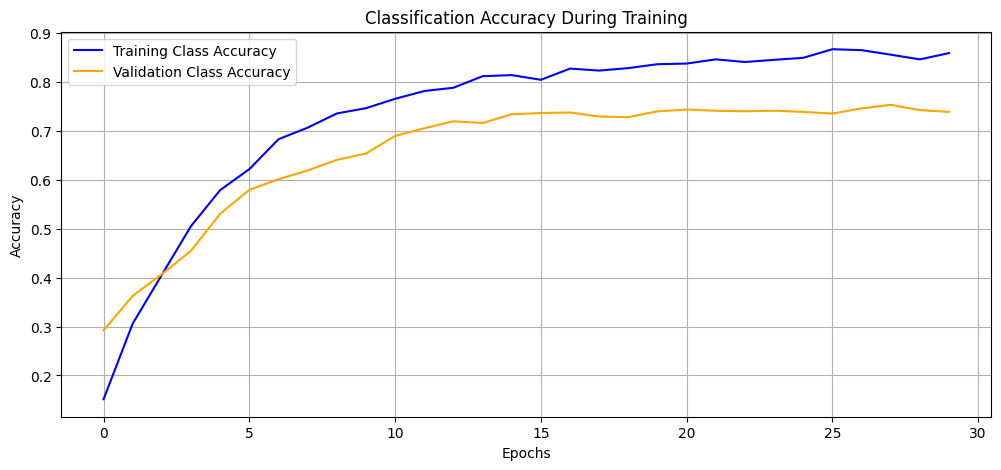

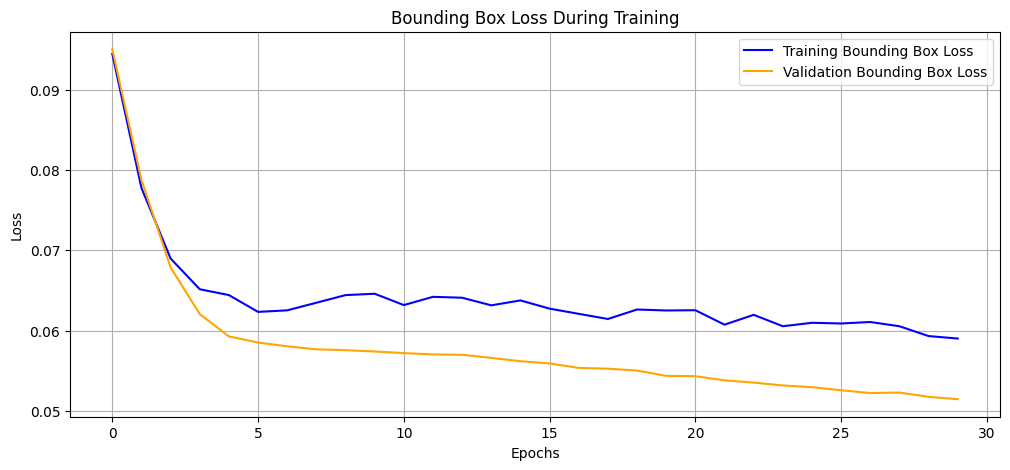

In [7]:
import matplotlib.pyplot as plt

# Extract data from history
loss = history.history['loss']
val_loss = history.history['val_loss']
class_accuracy = history.history['class_output_accuracy']
val_class_accuracy = history.history['val_class_output_accuracy']
bbox_loss = history.history['bbox_output_loss']
val_bbox_loss = history.history['val_bbox_output_loss']

# Plot Total Loss
plt.figure(figsize=(12, 5))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Total Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Classification Accuracy
plt.figure(figsize=(12, 5))
plt.plot(class_accuracy, label='Training Class Accuracy', color='blue')
plt.plot(val_class_accuracy, label='Validation Class Accuracy', color='orange')
plt.title('Classification Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Bounding Box Loss
plt.figure(figsize=(12, 5))
plt.plot(bbox_loss, label='Training Bounding Box Loss', color='blue')
plt.plot(val_bbox_loss, label='Validation Bounding Box Loss', color='orange')
plt.title('Bounding Box Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [1]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import io

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Function to display the uploaded image and predictions
def display_prediction(image_path):
    with output_widget:
        # Clear previous output
        output_widget.clear_output()
        
        # Preprocess the image
        preprocessed_image = preprocess_image(image_path)
        
        # Make predictions
        predictions = model.predict(preprocessed_image)
        
        # Extract classification and bounding box results
        class_probs = predictions[0][0]
        bbox_coords = predictions[1][0]
        
        # Get predicted class
        predicted_class_idx = np.argmax(class_probs)
        predicted_class_label = unique_classes[predicted_class_idx]
        confidence = class_probs[predicted_class_idx]
        
        # Display the image
        img = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        
        # Display bounding box (denormalize to original size)
        width, height = img.size
        xmin = int(bbox_coords[0] * width)
        ymin = int(bbox_coords[1] * height)
        xmax = int(bbox_coords[2] * width)
        ymax = int(bbox_coords[3] * height)
        
        plt.gca().add_patch(
            plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                          edgecolor='red', fill=False, linewidth=2)
        )
        plt.text(xmin, ymin - 10, f"{predicted_class_label} ({confidence:.2f})", 
                 color='red', fontsize=12, backgroundcolor='white')
        plt.axis('off')
        plt.show()

# Widget to upload an image
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False      # Single file upload
)

# Output widget to display results
output_widget = widgets.Output()

def on_upload_change(change):
    if uploader.value:
        # Extract uploaded file content
        uploaded_file = uploader.value[0]  # Access the first item in the tuple
        content = uploaded_file['content']
        
        # Save to a temporary file
        with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as tmp_file:
            tmp_file.write(content)  # Write content to file
            tmp_path = tmp_file.name
        
        # Display prediction
        display_prediction(tmp_path)

uploader.observe(on_upload_change, names='value')

# Display the uploader widget
print("Upload an image to test the model:")
display(widgets.VBox([uploader, output_widget]))


Upload an image to test the model:


In [10]:
# Save the model in .h5 format
model.save("model3.h5")

print("Model saved as 'model3.h5'")


Model saved as 'model3.h5'
